In [1]:
#!pip install -U flwr["simulation"]==1.9.0 torch torchvision GPUtil

In [1]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple, NamedTuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
import time
import flwr as fl
from scipy import stats as st
import json

DEVICE = torch.device("cuda")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cuda using PyTorch 2.3.1 and Flower 1.9.0


In [2]:
from logging import INFO, DEBUG
from flwr.common.logger import log

In [3]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
   process = psutil.Process(os.getpid())
   print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
   print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 116.8 GB  | Proc size: 511.0 MB
GPU RAM Free: 14812MB | Used: 1358MB | Util   8% | Total 16376MB


In [4]:
NUM_CLIENTS = 10


def load_datasets(num_clients: int):
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
    testset = CIFAR10("./dataset", train=False, download=True, transform=transform)

    # Split training set into `num_clients` partitions to simulate different local datasets
    partition_size = len(trainset) // num_clients
    lengths = [partition_size] * num_clients
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=32, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=32))
    testloader = DataLoader(testset, batch_size=32)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets(NUM_CLIENTS)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

class ClientMetrics(NamedTuple):
    epoch: int
    loss: float
    accuracy: float
    round: int = 0
    cid: int = 0

def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    metrics = []
    for epoch in range(epochs):  # Use the passed 'epochs' variable here
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss.item()  # Make sure to call .item() to get the scalar value
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        metrics.append(ClientMetrics(epoch, epoch_loss, epoch_acc))
        print(f"Epoch {epoch}: train loss {epoch_loss:.6f}, accuracy {epoch_acc:.6f}")
        
    return metrics


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [6]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        epochs = config.get("epochs", 1)
        start_time = time.time()  # Start time measurement
        metrics = train(self.net, self.trainloader, epochs)
        training_time = time.time() - start_time  # Calculate duration
        print(f"Training time for Client {self.cid}: {training_time:.2f} seconds")
        
        return get_parameters(self.net), len(self.trainloader), {"training_time": training_time, "metrics": json.dumps(metrics)}



    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader).to_client()

In [7]:
from typing import Callable, Union

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg


class FedCustom(fl.server.strategy.Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.client_training_times: Dict[int, List[float]] = {}
        self.client_metrics: Dict[int, List[ClientMetrics]] = {}
        self.loss_extreme: Dict[int, Tuple[int, float, float]] = {}
        self.accuracy_extreme: Dict[int, Tuple[int, float, float]] = {}
    def __repr__(self) -> str:
        return "FedCustom"

    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        return fl.common.ndarrays_to_parameters(ndarrays)

    def configure_fit(self, server_round: int, parameters: Parameters, client_manager: ClientManager):
        sample_size, min_num_clients = self.num_fit_clients(client_manager.num_available())
        clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)
        epochs_sc = 10
        

        standard_config = {"lr": 0.001, "epochs": epochs_sc}
        
        fit_configurations = []
        mode_time = []
        
        for client in clients:
            last_time = self.client_training_times.get(client.cid, [0,])[-1] # Default to 0 if no time recorded # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            print(f"This is ths last time not a fantasy {last_time}and {client.cid}habhhahah")
            
            
            mode_time.append(round(last_time,2))
            print(f"this is tehb mode time {mode_time}")
           

        modest_value = st.mode(np.array(mode_time))
        print(f"Yeh h modest valueueueueu{modest_value}")
        print(f"yeh h server round {server_round}")
        min_value, max_value= np.min(modest_value),np.max(modest_value)
        print(f"this is the min value {min_value} and this is the max value {max_value}")
      
        
        if min_value == max_value:
            epochs_hl = epochs_sc   
        else:
            epochs_hl = int(np.floor((max_value-min_value)/max_value * epochs_sc)) 

        higher_lr_config = {"lr": 0.0001, "epochs": epochs_hl}
        print(f"The epochs for the higher lr is {epochs_hl} and the epochs for the standard lr is {epochs_sc}")




        for client in clients:
            # Choose config based on the previous training time
            last_time = self.client_training_times.get(client.cid, [0,])[-1]  # Default to 0 if no time recorded # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            print(f"This is the last time {last_time}")
            
            


            config_to_use = standard_config if last_time < modest_value.mode else higher_lr_config
            fit_configurations.append((client, FitIns(parameters, config_to_use)))

        return fit_configurations
    
    def parse_metrics(self, cid: int, server_round: int, metrics: str): # this function has been added to parse the metrics from the client
        client_data: List[ClientMetrics] = json.loads(metrics)
        data_store: List[ClientMetrics] = self.client_metrics.setdefault(cid, [])
        last_epoch: int = len(data_store)
        for data in client_data:
            data_store.append(ClientMetrics(last_epoch, data[1], data[2], round=server_round, cid=cid))
            last_epoch += 1

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        for client, fit_res in results:
            # Update training times for each client
            self.client_training_times.setdefault(client.cid, []).append(fit_res.metrics.get("training_time", 0)) # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            self.parse_metrics(client.cid,server_round, fit_res.metrics.get("metrics", None))
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated


    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Evaluate global model parameters using an evalua
        tion function."""

        # Let's assume we won't perform the global model evaluation on the server side.
        
        return None

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients

In [8]:
if DEVICE.type == "cuda":
    # Use a single client to train the global model
    client_resources = {"num_gpus": .125, "num_cpus": 1} 

In [9]:
strategy = FedCustom()
#fl.common.logger.configure(identifier="myflExpMY", filename="FLLOG_my.txt")
history = fl.simulation.start_simulation(client_fn=client_fn,
                                         num_clients=10,
                                         config=fl.server.ServerConfig(num_rounds=10),
                                         strategy=strategy,  # <-- pass the new strategy here
                                         client_resources=client_resources,

)
history


INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-12-13 09:51:27,274	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 32.0, 'memory': 71401760564.0, 'node:127.0.0.1': 1.0, 'accelerator_type:RTX': 1.0, 'GPU': 1.0, 'object_store_memory': 34886468812.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_gpus': 0.125, 'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 0and 1habhhahah
this is tehb mode time [0]
This is ths last time not a fantasy 0and 4habhhahah
this is tehb mode time [0, 0]
This is ths last time not a fantasy 0and 5habhhahah
this is tehb mode time [0, 0, 0]
This is ths last time not a fantasy 0and 7habhhahah
this is tehb mode time [0, 0, 0, 0]
This is ths last time not a fantasy 0and 2habhhahah
this is tehb mode time [0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 3habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 9habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 8habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 6habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 0habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Yeh h modest valueueueueuModeResult(mode=0, count=10)
yeh h server round 1


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=41796) Epoch 9: train loss 0.035918, accuracy 0.586667 [repeated 5x across cluster]
(ClientAppActor pid=41796) [Client 3] evaluate, config: {}
(ClientAppActor pid=41796) Training time for Client 0: 22.80 seconds
(ClientAppActor pid=41672) [Client 7] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=41776) [Client 1] evaluate, config: {} [repeated 5x across cluster]
This is ths last time not a fantasy 21.745545148849487and 2habhhahah
this is tehb mode time [21.75]
This is ths last time not a fantasy 22.09492540359497and 9habhhahah
this is tehb mode time [21.75, 22.09]
This is ths last time not a fantasy 21.856375217437744and 3habhhahah
this is tehb mode time [21.75, 22.09, 21.86]
This is ths last time not a fantasy 22.0767560005188and 7habhhahah
this is tehb mode time [21.75, 22.09, 21.86, 22.08]
This is ths last time not a fantasy 21.961759328842163and 8habhhahah
this is tehb mode time [21.75, 22.09, 21.86, 22.08, 21.96]
This is ths last time not a fantasy 22.875126361846924and 6habhhahah
this is tehb mode time [21.75, 22.09, 21.86, 22.08, 21.96, 22.88]
This is ths last time not a fantasy 22.357508897781372and 1habhhahah
this is tehb mode time [21.75, 22.09, 21.86, 22.08, 21.96, 22.88, 22.36]
This is ths last time not a fantasy 21.853756427764893and 5habhhahah

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=41776) [Client 7] evaluate, config: {}
(ClientAppActor pid=41776) Epoch 8: train loss 0.025076, accuracy 0.718667 [repeated 2x across cluster]
(ClientAppActor pid=41776) Training time for Client 0: 20.78 seconds
(ClientAppActor pid=41648) [Client 6] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=41776) [Client 4] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.776328563690186and 0habhhahah
this is tehb mode time [20.78]
This is ths last time not a fantasy 19.659212589263916and 3habhhahah
this is tehb mode time [20.78, 19.66]
This is ths last time not a fantasy 18.918771505355835and 8habhhahah
this is tehb mode time [20.78, 19.66, 18.92]
This is ths last time not a fantasy 21.582056522369385and 2habhhahah
this is tehb mode time [20.78, 19.66, 18.92, 21.58]
This is ths last time not a fantasy 19.21493434906006and 7habhhahah
this is tehb mode time [20.78, 19.66, 18.92, 21.58, 19.21]
This is ths last time not a fantasy 19.160818576812744and 6habhhahah
this is tehb mode time [20.78, 19.66, 18.92, 21.58, 19.21, 19.16]
This is ths last time not a fantasy 20.54502034187317and 4habhhahah
this is tehb mode time [20.78, 19.66, 18.92, 21.58, 19.21, 19.16, 20.55]
This is ths last time not a fantasy 19.085904359817505and 1habhhahah
this is tehb mode time [20.78, 19.66, 18.92, 21.58, 19.21, 19.16, 20.55, 19.09]
This i

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=41648) [Client 8] evaluate, config: {}
(ClientAppActor pid=41648) Epoch 8: train loss 0.014934, accuracy 0.834667 [repeated 2x across cluster]
(ClientAppActor pid=41648) Training time for Client 9: 20.91 seconds
(ClientAppActor pid=41716) [Client 0] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=41640) [Client 3] evaluate, config: {} [repeated 5x across cluster]
This is ths last time not a fantasy 19.17197585105896and 6habhhahah
this is tehb mode time [19.17]
This is ths last time not a fantasy 20.908315896987915and 9habhhahah
this is tehb mode time [19.17, 20.91]
This is ths last time not a fantasy 19.105245113372803and 7habhhahah
this is tehb mode time [19.17, 20.91, 19.11]
This is ths last time not a fantasy 20.24367642402649and 0habhhahah
this is tehb mode time [19.17, 20.91, 19.11, 20.24]
This is ths last time not a fantasy 19.352972745895386and 4habhhahah
this is tehb mode time [19.17, 20.91, 19.11, 20.24, 19.35]
This is ths last time not a fantasy 21.30244016647339and 5habhhahah
this is tehb mode time [19.17, 20.91, 19.11, 20.24, 19.35, 21.3]
This is ths last time not a fantasy 19.120080947875977and 2habhhahah
this is tehb mode time [19.17, 20.91, 19.11, 20.24, 19.35, 21.3, 19.12]
This is ths last time not a fantasy 19.267810821533203and 1habhhahah
t

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=41776) [Client 2] evaluate, config: {}
(ClientAppActor pid=41776) Epoch 8: train loss 0.006234, accuracy 0.939778 [repeated 2x across cluster]
(ClientAppActor pid=41776) Training time for Client 8: 21.27 seconds
(ClientAppActor pid=41648) [Client 1] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 21.745092153549194and 7habhhahah
this is tehb mode time [21.75]
This is ths last time not a fantasy 19.229827642440796and 2habhhahah
this is tehb mode time [21.75, 19.23]
This is ths last time not a fantasy 19.2308292388916and 5habhhahah
this is tehb mode time [21.75, 19.23, 19.23]
This is ths last time not a fantasy 19.745117664337158and 4habhhahah
this is tehb mode time [21.75, 19.23, 19.23, 19.75]
This is ths last time not a fantasy 19.31037211418152and 0habhhahah
this is tehb mode time [21.75, 19.23, 19.23, 19.75, 19.31]
This is ths last time not a fantasy 19.951464891433716and 6habhhahah
this is tehb mode time [21.75, 19.23, 19.23, 19.75, 19.31, 19.95]
This is ths last time not a fantasy 19.194119691848755and 1habhhahah
this is tehb mode time [21.75, 19.23, 19.23, 19.75, 19.31, 19.95, 19.19]
This is ths last time not a fantasy 21.2737238407135and 8habhhahah
this is tehb mode time [21.75, 19.23, 19.23, 19.75, 19.31, 19.95, 19.19, 21.27]
This is t

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=41672) [Client 5] evaluate, config: {}
(ClientAppActor pid=41672) Training time for Client 9: 17.99 seconds
(ClientAppActor pid=41672) Epoch 7: train loss 0.005303, accuracy 0.952000 [repeated 2x across cluster]
(ClientAppActor pid=41796) [Client 7] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 17.156270503997803and 4habhhahah
this is tehb mode time [17.16]
This is ths last time not a fantasy 17.059122323989868and 5habhhahah
this is tehb mode time [17.16, 17.06]
This is ths last time not a fantasy 17.6459698677063and 3habhhahah
this is tehb mode time [17.16, 17.06, 17.65]
This is ths last time not a fantasy 17.339924097061157and 0habhhahah
this is tehb mode time [17.16, 17.06, 17.65, 17.34]
This is ths last time not a fantasy 21.83520531654358and 2habhhahah
this is tehb mode time [17.16, 17.06, 17.65, 17.34, 21.84]
This is ths last time not a fantasy 17.351840496063232and 8habhhahah
this is tehb mode time [17.16, 17.06, 17.65, 17.34, 21.84, 17.35]
This is ths last time not a fantasy 17.525365352630615and 7habhhahah
this is tehb mode time [17.16, 17.06, 17.65, 17.34, 21.84, 17.35, 17.53]
This is ths last time not a fantasy 17.992400884628296and 9habhhahah
this is tehb mode time [17.16, 17.06, 17.65, 17.34, 21.84, 17.35, 17.53, 17.99]
This is

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=41672) [Client 3] evaluate, config: {}
(ClientAppActor pid=41672) Training time for Client 6: 21.08 seconds
(ClientAppActor pid=41672) Epoch 8: train loss 0.004050, accuracy 0.962000 [repeated 2x across cluster]
(ClientAppActor pid=41796) [Client 6] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 18.984711408615112and 8habhhahah
this is tehb mode time [18.98]
This is ths last time not a fantasy 19.935558795928955and 7habhhahah
this is tehb mode time [18.98, 19.94]
This is ths last time not a fantasy 21.077553510665894and 6habhhahah
this is tehb mode time [18.98, 19.94, 21.08]
This is ths last time not a fantasy 19.485015392303467and 3habhhahah
this is tehb mode time [18.98, 19.94, 21.08, 19.49]
This is ths last time not a fantasy 19.863511085510254and 4habhhahah
this is tehb mode time [18.98, 19.94, 21.08, 19.49, 19.86]
This is ths last time not a fantasy 19.7177152633667and 2habhhahah
this is tehb mode time [18.98, 19.94, 21.08, 19.49, 19.86, 19.72]
This is ths last time not a fantasy 21.898917198181152and 5habhhahah
this is tehb mode time [18.98, 19.94, 21.08, 19.49, 19.86, 19.72, 21.9]
This is ths last time not a fantasy 19.461015939712524and 0habhhahah
this is tehb mode time [18.98, 19.94, 21.08, 19.49, 19.86, 19.72, 21.9, 19.46]
This is 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=41716) [Client 6] evaluate, config: {}
(ClientAppActor pid=41716) Training time for Client 9: 20.64 seconds
(ClientAppActor pid=41716) Epoch 8: train loss 0.002318, accuracy 0.980444
(ClientAppActor pid=41716) [Client 7] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 19.730316162109375and 5habhhahah
this is tehb mode time [19.73]
This is ths last time not a fantasy 20.134809732437134and 8habhhahah
this is tehb mode time [19.73, 20.13]
This is ths last time not a fantasy 18.884557247161865and 3habhhahah
this is tehb mode time [19.73, 20.13, 18.88]
This is ths last time not a fantasy 19.6557400226593and 0habhhahah
this is tehb mode time [19.73, 20.13, 18.88, 19.66]
This is ths last time not a fantasy 20.643381357192993and 9habhhahah
this is tehb mode time [19.73, 20.13, 18.88, 19.66, 20.64]
This is ths last time not a fantasy 19.24746322631836and 2habhhahah
this is tehb mode time [19.73, 20.13, 18.88, 19.66, 20.64, 19.25]
This is ths last time not a fantasy 19.060789585113525and 4habhhahah
this is tehb mode time [19.73, 20.13, 18.88, 19.66, 20.64, 19.25, 19.06]
This is ths last time not a fantasy 19.559558629989624and 6habhhahah
this is tehb mode time [19.73, 20.13, 18.88, 19.66, 20.64, 19.25, 19.06, 19.56]
This is

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=41776) [Client 9] evaluate, config: {}
(ClientAppActor pid=41776) Training time for Client 7: 21.11 seconds
(ClientAppActor pid=41776) Epoch 8: train loss 0.000827, accuracy 0.996889
(ClientAppActor pid=41716) [Client 6] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 19.768190383911133and 4habhhahah
this is tehb mode time [19.77]
This is ths last time not a fantasy 19.433687210083008and 2habhhahah
this is tehb mode time [19.77, 19.43]
This is ths last time not a fantasy 21.110573291778564and 7habhhahah
this is tehb mode time [19.77, 19.43, 21.11]
This is ths last time not a fantasy 20.104884386062622and 5habhhahah
this is tehb mode time [19.77, 19.43, 21.11, 20.1]
This is ths last time not a fantasy 19.820088148117065and 8habhhahah
this is tehb mode time [19.77, 19.43, 21.11, 20.1, 19.82]
This is ths last time not a fantasy 19.215599060058594and 0habhhahah
this is tehb mode time [19.77, 19.43, 21.11, 20.1, 19.82, 19.22]
This is ths last time not a fantasy 19.338191747665405and 6habhhahah
this is tehb mode time [19.77, 19.43, 21.11, 20.1, 19.82, 19.22, 19.34]
This is ths last time not a fantasy 20.712445497512817and 1habhhahah
this is tehb mode time [19.77, 19.43, 21.11, 20.1, 19.82, 19.22, 19.34, 20.71]
This is t

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=41756) Epoch 9: train loss 0.005188, accuracy 0.944000 [repeated 4x across cluster]
(ClientAppActor pid=41756) Training time for Client 9: 22.74 seconds
(ClientAppActor pid=41756) [Client 0] evaluate, config: {}
(ClientAppActor pid=41736) [Client 8] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 17.941502571105957and 3habhhahah
this is tehb mode time [17.94]
This is ths last time not a fantasy 17.787782192230225and 8habhhahah
this is tehb mode time [17.94, 17.79]
This is ths last time not a fantasy 17.203964471817017and 5habhhahah
this is tehb mode time [17.94, 17.79, 17.2]
This is ths last time not a fantasy 21.63939595222473and 6habhhahah
this is tehb mode time [17.94, 17.79, 17.2, 21.64]
This is ths last time not a fantasy 17.220069885253906and 2habhhahah
this is tehb mode time [17.94, 17.79, 17.2, 21.64, 17.22]
This is ths last time not a fantasy 17.38453507423401and 1habhhahah
this is tehb mode time [17.94, 17.79, 17.2, 21.64, 17.22, 17.38]
This is ths last time not a fantasy 17.29306650161743and 7habhhahah
this is tehb mode time [17.94, 17.79, 17.2, 21.64, 17.22, 17.38, 17.29]
This is ths last time not a fantasy 18.057746171951294and 4habhhahah
this is tehb mode time [17.94, 17.79, 17.2, 21.64, 17.22, 17.38, 17.29, 18.06]
This is ths l

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=41796) [Client 3] evaluate, config: {}
(ClientAppActor pid=41796) Epoch 8: train loss 0.009412, accuracy 0.902444 [repeated 2x across cluster]
(ClientAppActor pid=41796) Training time for Client 0: 20.74 seconds
(ClientAppActor pid=41640) [Client 8] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 581.52s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.053527183461189266
INFO :      		round 2: 0.04337338440418244
INFO :      		round 3: 0.04602763713598251
INFO :      		round 4: 0.053860840606689456
INFO :      		round 5: 0.05891626038551331
INFO :      		round 6: 0.06442783061265946
INFO :      		round 7: 0.0684188344836235
INFO :      		round 8: 0.07074012100696564
INFO :      		round 9: 0.07335910124778747
INFO :      		round 10: 0.07267115644216537
INFO :      


History (loss, distributed):
	round 1: 0.053527183461189266
	round 2: 0.04337338440418244
	round 3: 0.04602763713598251
	round 4: 0.053860840606689456
	round 5: 0.05891626038551331
	round 6: 0.06442783061265946
	round 7: 0.0684188344836235
	round 8: 0.07074012100696564
	round 9: 0.07335910124778747
	round 10: 0.07267115644216537

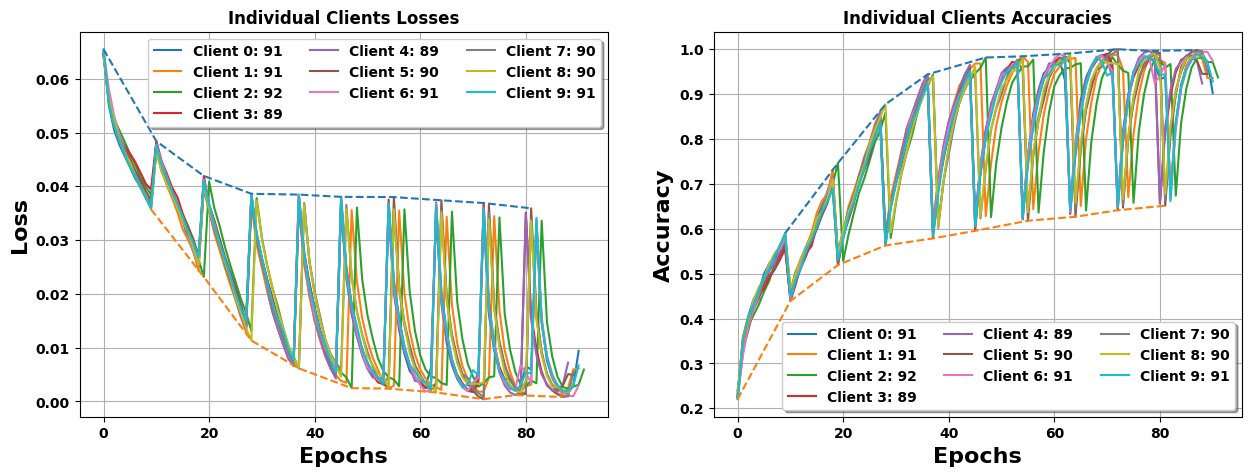

In [99]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.weight'] = 'bold'

def plot_metrics(client_metrics, rounds: int = 10):
    # client_metrics = strategy.client_metrics
    client_ids = list(client_metrics.keys())
    client_ids.sort()
   


    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    round_max_losses: List[Tuple[int, float]] = []
    round_max_accuracy: List[Tuple[int, float]] = []
    round_min_losses: List[Tuple[int, float]] = []
    round_min_accuracy: List[Tuple[int, float]] = []
    
    

    for round in range(1, rounds+1):
        metrics_round = [(metrics.epoch, metrics.loss, metrics.accuracy) for metrics_list in client_metrics.values()
                       for metrics in metrics_list if metrics.round == round]
        if metrics_round:
            min_loss = min(metrics_round, key=lambda x: x[1])
            max_loss = max(metrics_round, key=lambda x: x[1])
            round_max_losses.append(max_loss)
            round_min_losses.append(min_loss)
            min_accuracy = min(metrics_round, key=lambda x: x[2])
            max_accuracy = max(metrics_round, key=lambda x: x[2])
            round_max_accuracy.append(max_accuracy)
            round_min_accuracy.append(min_accuracy)

    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        losses = [metric.loss for metric in client_metrics[cid]]
        axs[0].plot(epochs, losses,label=f"Client {cid}: {len(strategy.client_metrics[cid])}")

    max_epochs = [round_max[0] for round_max in round_max_losses]
    max_losses = [round_max[1] for round_max in round_max_losses]
    min_epochs = [round_min[0] for round_min in round_min_losses]
    min_losses = [round_min[1] for round_min in round_min_losses]
    
    axs[0].plot(max_epochs, max_losses, linestyle='dashed')
    axs[0].plot(min_epochs, min_losses, linestyle='dashed')
    axs[0].set_title("Individual Clients Losses",weight='bold')
    axs[0].set_xlabel("Epochs", fontsize=16,weight='bold')
    axs[0].set_ylabel("Loss",fontsize=16,weight='bold')
    axs[0].legend(loc='upper right', shadow=True,ncol=3)
    axs[0].grid()
    


    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        accuracies = [metric.accuracy for metric in client_metrics[cid]]
        axs[1].plot(epochs, accuracies, label=f"Client {cid}: {len(client_metrics[cid])}")

    max_epochs = [round_max[0] for round_max in round_max_accuracy]
    max_accuracies = [round_max[2] for round_max in round_max_accuracy]
    min_epochs = [round_min[0] for round_min in round_min_accuracy]
    min_accuracies = [round_min[2] for round_min in round_min_accuracy]
    
    axs[1].plot(max_epochs, max_accuracies, linestyle='dashed')
    axs[1].plot(min_epochs, min_accuracies, linestyle='dashed')
    axs[1].set_title("Individual Clients Accuracies",weight='bold')

    axs[1].set_xlabel("Epochs", fontsize=16,weight='bold')
    axs[1].set_ylabel("Accuracy",fontsize=16,weight='bold')
    axs[1].legend(loc='lower right', shadow=True, ncol=3,fontsize=10)
    axs[1].grid()

    plt.show()

plot_metrics(strategy.client_metrics)

Seperate Loss

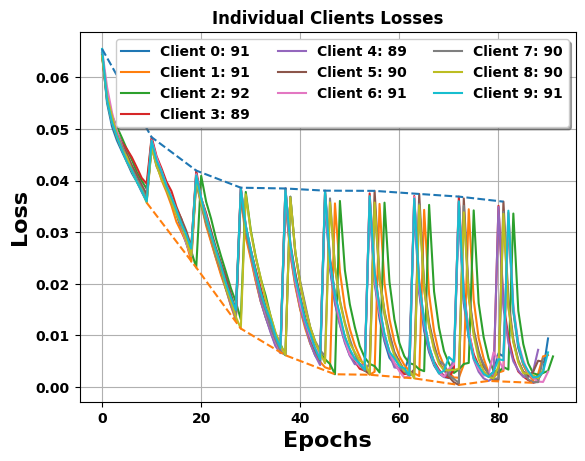

In [104]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.weight'] = 'bold'

def plot_metrics_loss(client_metrics, rounds: int = 10):
    # client_metrics = strategy.client_metrics
    client_ids = list(client_metrics.keys())
    client_ids.sort()
    axs = plt
   


    #fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    round_max_losses: List[Tuple[int, float]] = []
    round_max_accuracy: List[Tuple[int, float]] = []
    round_min_losses: List[Tuple[int, float]] = []
    round_min_accuracy: List[Tuple[int, float]] = []
    
    

    for round in range(1, rounds+1):
        metrics_round = [(metrics.epoch, metrics.loss, metrics.accuracy) for metrics_list in client_metrics.values()
                       for metrics in metrics_list if metrics.round == round]
        if metrics_round:
            min_loss = min(metrics_round, key=lambda x: x[1])
            max_loss = max(metrics_round, key=lambda x: x[1])
            round_max_losses.append(max_loss)
            round_min_losses.append(min_loss)
            min_accuracy = min(metrics_round, key=lambda x: x[2])
            max_accuracy = max(metrics_round, key=lambda x: x[2])
            round_max_accuracy.append(max_accuracy)
            round_min_accuracy.append(min_accuracy)

    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        losses = [metric.loss for metric in client_metrics[cid]]
        axs.plot(epochs, losses,label=f"Client {cid}: {len(strategy.client_metrics[cid])}")

    max_epochs = [round_max[0] for round_max in round_max_losses]
    max_losses = [round_max[1] for round_max in round_max_losses]
    min_epochs = [round_min[0] for round_min in round_min_losses]
    min_losses = [round_min[1] for round_min in round_min_losses]
    
    axs.plot(max_epochs, max_losses, linestyle='dashed')
    axs.plot(min_epochs, min_losses, linestyle='dashed')
    axs.title("Individual Clients Losses",weight='bold')
    axs.xlabel("Epochs", fontsize=16,weight='bold')
    axs.ylabel("Loss",fontsize=16,weight='bold')
    axs.legend(loc='upper right', shadow=True,ncol=3)
    axs.grid()
    


plot_metrics_loss(strategy.client_metrics)

Accuracy Sperate

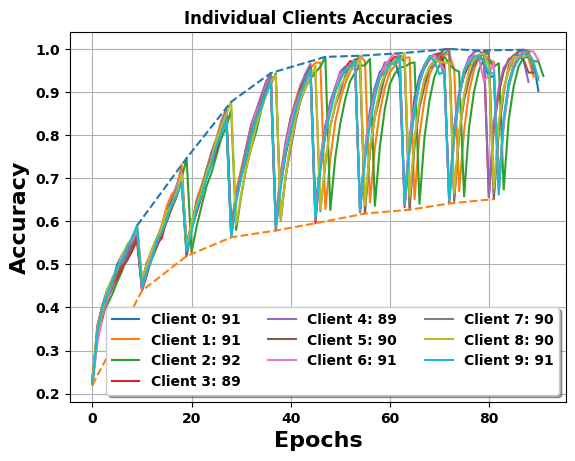

In [105]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.weight'] = 'bold'

def plot_metrics_acc(client_metrics, rounds: int = 10):
    # client_metrics = strategy.client_metrics
    client_ids = list(client_metrics.keys())
    client_ids.sort()
    axs = plt
   


    #fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    round_max_losses: List[Tuple[int, float]] = []
    round_max_accuracy: List[Tuple[int, float]] = []
    round_min_losses: List[Tuple[int, float]] = []
    round_min_accuracy: List[Tuple[int, float]] = []
    
    

    for round in range(1, rounds+1):
        metrics_round = [(metrics.epoch, metrics.loss, metrics.accuracy) for metrics_list in client_metrics.values()
                       for metrics in metrics_list if metrics.round == round]
        if metrics_round:
            min_loss = min(metrics_round, key=lambda x: x[1])
            max_loss = max(metrics_round, key=lambda x: x[1])
            round_max_losses.append(max_loss)
            round_min_losses.append(min_loss)
            min_accuracy = min(metrics_round, key=lambda x: x[2])
            max_accuracy = max(metrics_round, key=lambda x: x[2])
            round_max_accuracy.append(max_accuracy)
            round_min_accuracy.append(min_accuracy)

   


    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        accuracies = [metric.accuracy for metric in client_metrics[cid]]
        axs.plot(epochs, accuracies, label=f"Client {cid}: {len(client_metrics[cid])}")

    max_epochs = [round_max[0] for round_max in round_max_accuracy]
    max_accuracies = [round_max[2] for round_max in round_max_accuracy]
    min_epochs = [round_min[0] for round_min in round_min_accuracy]
    min_accuracies = [round_min[2] for round_min in round_min_accuracy]
    
    axs.plot(max_epochs, max_accuracies, linestyle='dashed')
    axs.plot(min_epochs, min_accuracies, linestyle='dashed')
    axs.title("Individual Clients Accuracies",weight='bold')

    axs.xlabel("Epochs", fontsize=16,weight='bold')
    axs.ylabel("Accuracy",fontsize=16,weight='bold')
    axs.legend(loc='lower right', shadow=True, ncol=3,fontsize=10)
    axs.grid()

    plt.show()

plot_metrics_acc(strategy.client_metrics)

{'9': [ClientMetrics(epoch=0, loss=0.06549359893798828, accuracy=0.22022222222222224, round=1, cid='9'), ClientMetrics(epoch=1, loss=0.05557866329616971, accuracy=0.3453333333333333, round=1, cid='9'), ClientMetrics(epoch=2, loss=0.05127967262268066, accuracy=0.40155555555555555, round=1, cid='9'), ClientMetrics(epoch=3, loss=0.04852330605189006, accuracy=0.43044444444444446, round=1, cid='9'), ClientMetrics(epoch=4, loss=0.04595282877816094, accuracy=0.462, round=1, cid='9'), ClientMetrics(epoch=5, loss=0.04365699219703674, accuracy=0.492, round=1, cid='9'), ClientMetrics(epoch=6, loss=0.04194748287730747, accuracy=0.5113333333333333, round=1, cid='9'), ClientMetrics(epoch=7, loss=0.03976885787645976, accuracy=0.5395555555555556, round=1, cid='9'), ClientMetrics(epoch=8, loss=0.03804716180430518, accuracy=0.5606666666666666, round=1, cid='9'), ClientMetrics(epoch=9, loss=0.03593716975053152, accuracy=0.59, round=1, cid='9'), ClientMetrics(epoch=10, loss=0.047692737340927126, accuracy=

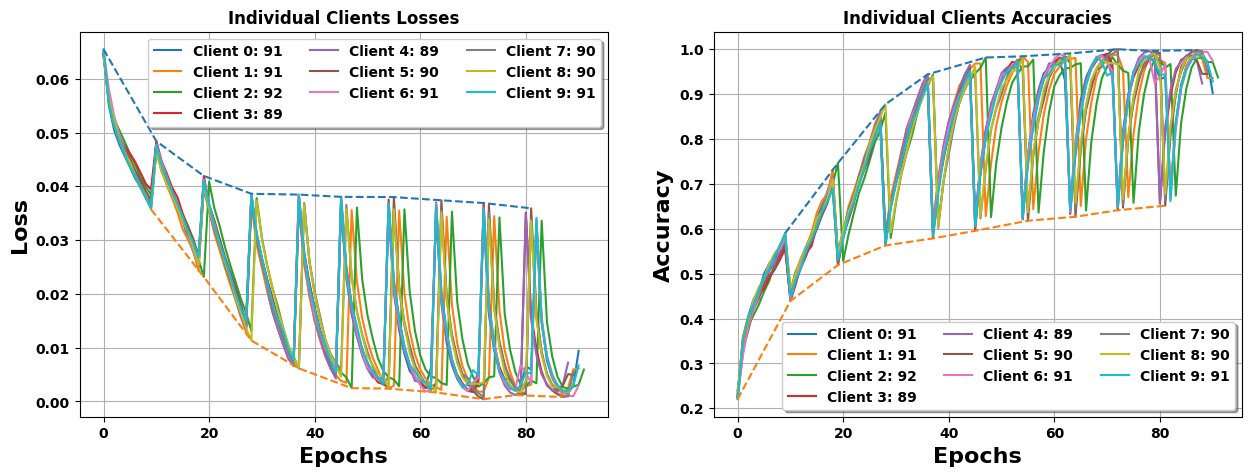

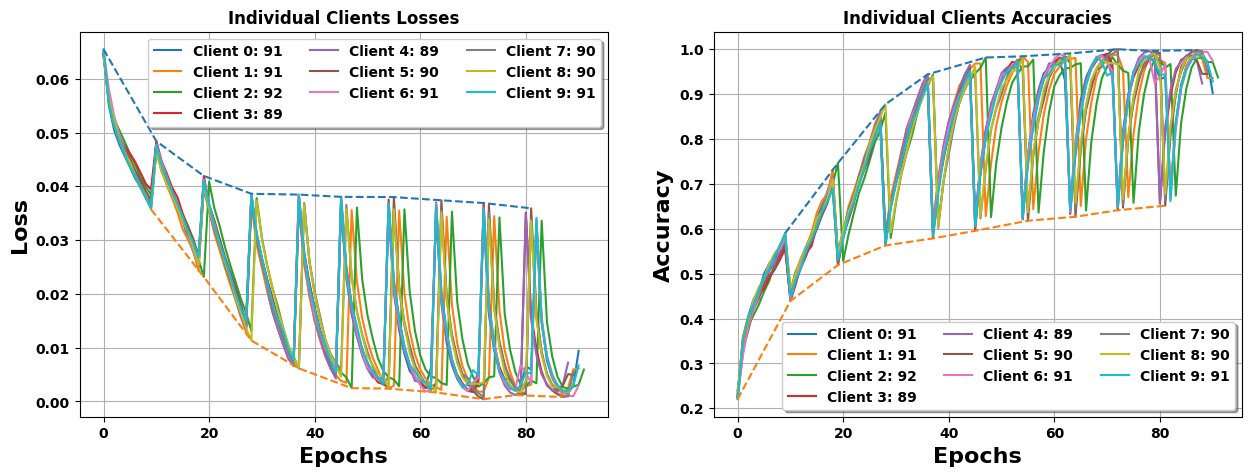

In [ ]:
# def save_data(client_metrics, rounds: int = 10):
#     with open("data1.json", "w") as data:
#         data.write(json.dumps(client_metrics))
# save_data(strategy.client_metrics)
def load_data(file_path: str) -> Dict[str, List[ClientMetrics]]:
    with open(file_path, "r") as data:
        loaded_data = json.load(data)
        client_metrics = {k: [ClientMetrics(*metric) for metric in v] for k, v in loaded_data.items()}
    return client_metrics

loaded_client_metrics = load_data("data1.json")
print(loaded_client_metrics)
print(strategy.client_metrics)
plot_metrics(loaded_client_metrics)
plot_metrics(strategy.client_metrics)
# def parse_metrics(metrics): # this function has been added to parse the metrics from the client
#     for data in metrics:
#         return ClientMetrics(data[0], data[1], data[2], data[3], data[4])

# loaded_data = {}
# with open("data.json", "r") as data:
#     loaded_data = json.load(data)

# print(strategy.client_metrics)
# print(loaded_data)

[3, 4, 4, 4, 4, 4]
<class 'list'>


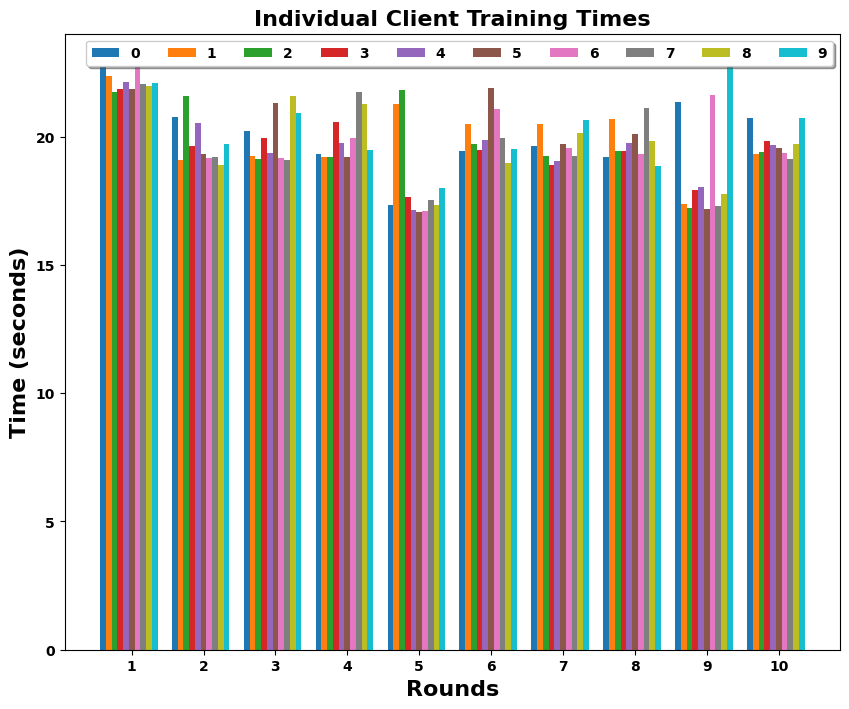

In [87]:
def plot_times(client_training_times):
    client_ids = list(client_training_times.keys())
    client_ids.sort()
    num_rounds = len(client_training_times[client_ids[0]])

    x = np.arange(num_rounds)  # Positions of the bars
    bar_width = 0.08 # Width of bars
    fig, ax = plt.subplots(figsize=(10, 8))

    for i, client_id in enumerate(client_ids):
        times = client_training_times[client_id]
        ax.bar(x + i * bar_width, times, bar_width, label=client_id)

    ax.set_xlabel("Rounds",fontsize=16,weight='bold')
    ax.set_ylabel("Time (seconds)",fontsize=16,weight='bold')
    ax.set_title("Individual Client Training Times",fontsize=16,weight='bold')
    ax.set_xticks(x + bar_width * round(len(client_ids) / 2))
    ax.set_xticklabels(np.arange(1, num_rounds + 1))
    ax.legend(loc='upper right', shadow=True, ncol=len(client_ids))

    plt.show()

plot_times(strategy.client_training_times)

In [12]:
for a in strategy.client_metrics:
    print(f"Client {a} metrics: {len(strategy.client_metrics[a])}")

Client 9 metrics: 91
Client 2 metrics: 92
Client 4 metrics: 89
Client 1 metrics: 91
Client 8 metrics: 90
Client 6 metrics: 91
Client 0 metrics: 91
Client 5 metrics: 90
Client 3 metrics: 89
Client 7 metrics: 90


In [13]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        start_time = time.time()  # Start time measurement
        metrics = train(self.net, self.trainloader, epochs=10)
        training_time = time.time() - start_time  # Calculate duration
        return get_parameters(self.net), len(self.trainloader), {"training_time": training_time, "metrics": json.dumps(metrics)}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        print(f"Client {self.cid} loss {loss}")
        print(f"Client {self.cid} accuracy {accuracy}")
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE) #Load Model from here
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader).to_client()

In [14]:
class FedAvgCustom(fl.server.strategy.FedAvg):
    def __init__(
        self,
        fraction_fit = 1.0,
        fraction_evaluate = 1.0,
        min_fit_clients = 2,
        min_evaluate_clients = 2,
        min_available_clients = 2,
    ):
        super().__init__(fraction_fit = fraction_fit, fraction_evaluate = fraction_evaluate, min_fit_clients = min_fit_clients, min_evaluate_clients = min_evaluate_clients, min_available_clients = min_available_clients)
        self.client_training_times: Dict[int, List[float]] = {}
        self.client_metrics: Dict[int, List[ClientMetrics]] = {}
        self.loss_extreme: Dict[int, Tuple[int, float, float]] = {}
        self.accuracy_extreme: Dict[int, Tuple[int, float, float]] = {}

    def parse_metrics(self, cid: int, server_round: int, metrics: str):
        client_data: List[ClientMetrics] = json.loads(metrics)
        data_store: List[ClientMetrics] = self.client_metrics.setdefault(cid, [])
        last_epoch: int = len(data_store)
        for data in client_data:
            data_store.append(ClientMetrics(last_epoch, data[1], data[2], round=server_round, cid=cid))
            last_epoch += 1

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        for client, fit_res in results:
            self.client_training_times.setdefault(client.cid, []).append(fit_res.metrics.get("training_time", 0))
            self.parse_metrics(client.cid, server_round, fit_res.metrics.get("metrics", None))
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated



In [15]:
class FedProxCustom(fl.server.strategy.FedProx):
    def __init__(
        self,
        fraction_fit = 1.0,
        fraction_evaluate = 1.0,
        min_fit_clients = 2,
        min_evaluate_clients = 2,
        min_available_clients = 2,
        proximal_mu=1.0,
    ):
        super().__init__(fraction_fit = fraction_fit, fraction_evaluate = fraction_evaluate, min_fit_clients = min_fit_clients, min_evaluate_clients = min_evaluate_clients, min_available_clients = min_available_clients,proximal_mu=proximal_mu)
        self.client_training_times: Dict[int, List[float]] = {}
        self.client_metrics: Dict[int, List[ClientMetrics]] = {}
        self.loss_extreme: Dict[int, Tuple[int, float, float]] = {}
        self.accuracy_extreme: Dict[int, Tuple[int, float, float]] = {}

    def parse_metrics(self, cid: int, server_round: int, metrics: str):
        client_data: List[ClientMetrics] = json.loads(metrics)
        data_store: List[ClientMetrics] = self.client_metrics.setdefault(cid, [])
        last_epoch: int = len(data_store)
        for data in client_data:
            data_store.append(ClientMetrics(last_epoch, data[1], data[2], round=server_round, cid=cid))
            last_epoch += 1

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        for client, fit_res in results:
            self.client_training_times.setdefault(client.cid, []).append(fit_res.metrics.get("training_time", 0))
            self.parse_metrics(client.cid, server_round, fit_res.metrics.get("metrics", None))
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated



In [16]:
#from flwr.server.strategy import FedProx

In [17]:
#strategy_fed_avg = FedAvgCustom()
#strategy_fed_prox = fl.server.strategy.FedProx(proximal_mu=1.0)
strategy_fed_prox = FedProxCustom()

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=10,
    config=fl.server.ServerConfig(num_rounds=10),
    client_resources=client_resources,
    strategy= strategy_fed_prox,
)

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-12-13 10:01:21,067	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 32.0, 'memory': 71141986509.0, 'node:127.0.0.1': 1.0, 'accelerator_type:RTX': 1.0, 'GPU': 1.0, 'object_store_memory': 34775137075.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_gpus': 0.125, 'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=29668) [Client 4] get_parameters
(ClientAppActor pid=29668) [Client 5] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=29668) Epoch 0: train loss 0.065241, accuracy 0.230889
(ClientAppActor pid=29668) Epoch 1: train loss 0.056356, accuracy 0.342000
(ClientAppActor pid=22432) [Client 8] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=29668) Epoch 2: train loss 0.052269, accuracy 0.386667
(ClientAppActor pid=25768) [Client 0] fit, config: {'proximal_mu': 1.0} [repeated 4x across cluster]
(ClientAppActor pid=42792) Epoch 1: train loss 0.055178, accuracy 0.337333 [repeated 10x across cluster]
(ClientAppActor pid=11904) [Client 2] fit, config: {'proximal_mu': 1.0} [repeated 2x across cluster]
(ClientAppActor pid=42492) Epoch 4: train loss 0.046271, accuracy 0.470444 [repeated 19x across cluster]
(ClientAppActor pid=29668) [Client 7] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=27184) Epoch 4: train loss 0.047205, accuracy 0.448444 [repeated 18x acros

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=22432) Epoch 9: train loss 0.035617, accuracy 0.587111 [repeated 3x across cluster]
(ClientAppActor pid=22432) [Client 5] evaluate, config: {}
(ClientAppActor pid=22432) Client 5 loss 0.05201497006416321
(ClientAppActor pid=22432) Client 5 accuracy 0.474
(ClientAppActor pid=25768) [Client 4] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=27184) Client 6 loss 0.05379995203018188 [repeated 3x across cluster]
(ClientAppActor pid=27184) Client 6 accuracy 0.416 [repeated 3x across cluster]
(ClientAppActor pid=42492) [Client 3] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=42492) Client 3 loss 0.05340551996231079 [repeated 5x across cluster]
(ClientAppActor pid=42492) Client 3 accuracy 0.41 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=11904) [Client 6] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=11904) Epoch 0: train loss 0.048130, accuracy 0.445333
(ClientAppActor pid=11904) [Client 8] evaluate, config: {}
(ClientAppActor pid=11904) Client 8 loss 0.054194732904434204
(ClientAppActor pid=11904) Client 8 accuracy 0.44
(ClientAppActor pid=42792) [Client 2] fit, config: {'proximal_mu': 1.0} [repeated 5x across cluster]
(ClientAppActor pid=42792) Epoch 0: train loss 0.047370, accuracy 0.455111 [repeated 11x across cluster]
(ClientAppActor pid=22432) [Client 0] fit, config: {'proximal_mu': 1.0} [repeated 2x across cluster]
(ClientAppActor pid=29668) Epoch 2: train loss 0.040515, accuracy 0.528222 [repeated 20x across cluster]
(ClientAppActor pid=27184) Epoch 7: train loss 0.027220, accuracy 0.682889 [repeated 17x across cluster]
(ClientAppActor pid=11904) [Client 1] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=27184) Epoch 9: train loss 0.021275, accuracy 0.758000 [repeated 17x acro

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=27184) Epoch 9: train loss 0.020333, accuracy 0.771333 [repeated 5x across cluster]
(ClientAppActor pid=27184) [Client 8] evaluate, config: {}
(ClientAppActor pid=27184) Client 8 loss 0.042790894389152526
(ClientAppActor pid=27184) Client 8 accuracy 0.534
(ClientAppActor pid=42792) [Client 9] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=27184) Client 6 loss 0.042314122200012204 [repeated 4x across cluster]
(ClientAppActor pid=27184) Client 6 accuracy 0.556 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=11904) [Client 4] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=11904) Client 4 loss 0.042665660619735715 [repeated 5x across cluster]
(ClientAppActor pid=11904) Client 4 accuracy 0.498 [repeated 5x across cluster]
(ClientAppActor pid=11904) [Client 6] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=11904) Epoch 0: train loss 0.040603, accuracy 0.535111
(ClientAppActor pid=27184) [Client 4] fit, config: {'proximal_mu': 1.0} [repeated 4x across cluster]
(ClientAppActor pid=27184) Epoch 0: train loss 0.040012, accuracy 0.546000 [repeated 8x across cluster]
(ClientAppActor pid=22432) [Client 2] fit, config: {'proximal_mu': 1.0} [repeated 3x across cluster]
(ClientAppActor pid=29668) Epoch 2: train loss 0.029504, accuracy 0.664444 [repeated 22x across cluster]
(ClientAppActor pid=528) Epoch 6: train loss 0.016246, accuracy 0.817333 [repeated 19x across cluster]
(ClientAppActor pid=11904) [Client 3] fit, config: {'proximal_mu': 1.0}
(ClientA

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=42492) Epoch 9: train loss 0.009591, accuracy 0.896000 [repeated 5x across cluster]
(ClientAppActor pid=42492) [Client 8] evaluate, config: {}
(ClientAppActor pid=42492) Client 8 loss 0.04856096196174622
(ClientAppActor pid=42492) Client 8 accuracy 0.538
(ClientAppActor pid=11904) [Client 0] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=11904) Client 0 loss 0.050106096982955935 [repeated 4x across cluster]
(ClientAppActor pid=11904) Client 0 accuracy 0.56 [repeated 4x across cluster]
(ClientAppActor pid=22432) [Client 7] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=27184) [Client 3] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=27184) Client 2 loss 0.05565397691726685 [repeated 5x across cluster]
(ClientAppActor pid=27184) Client 2 accuracy 0.526 [repeated 5x across cluster]
(ClientAppActor pid=27184) [Client 2] evaluate, config: {}
(ClientAppActor pid=27184) Epoch 0: train loss 0.038406, accuracy 0.571333
(ClientAppActor pid=42792) [Client 1] fit, config: {'proximal_mu': 1.0} [repeated 4x across cluster]
(ClientAppActor pid=11904) Epoch 2: train loss 0.023433, accuracy 0.742000 [repeated 12x across cluster]
(ClientAppActor pid=25768) [Client 7] fit, config: {'proximal_mu': 1.0} [repeated 3x across cluster]
(ClientAppActor pid=22432) Epoch 4: train loss 0.015545, accuracy 0.831111 [repeated 20x across cluster]
(ClientAppActor pid=42792) Epoch 6: train loss 0.008568, accuracy 0.908889 [repeated 21x across cluster]
(ClientAppActor pid=27184) [Client 9] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=22432) Epoch 9:

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=42492) Epoch 9: train loss 0.003624, accuracy 0.969111 [repeated 5x across cluster]
(ClientAppActor pid=42492) [Client 6] evaluate, config: {}
(ClientAppActor pid=42492) Client 6 loss 0.057786696195602415
(ClientAppActor pid=42492) Client 6 accuracy 0.58
(ClientAppActor pid=42792) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=29668) Client 7 loss 0.05507079863548279 [repeated 4x across cluster]
(ClientAppActor pid=29668) Client 7 accuracy 0.592 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=42492) [Client 5] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=42492) Client 5 loss 0.05176932990550995 [repeated 5x across cluster]
(ClientAppActor pid=42492) Client 5 accuracy 0.586 [repeated 5x across cluster]
(ClientAppActor pid=42492) [Client 6] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=42492) Epoch 0: train loss 0.038236, accuracy 0.595333
(ClientAppActor pid=42792) [Client 3] fit, config: {'proximal_mu': 1.0} [repeated 3x across cluster]
(ClientAppActor pid=528) Epoch 0: train loss 0.037325, accuracy 0.605333 [repeated 11x across cluster]
(ClientAppActor pid=11904) [Client 0] fit, config: {'proximal_mu': 1.0} [repeated 4x across cluster]
(ClientAppActor pid=25768) Epoch 4: train loss 0.010198, accuracy 0.894667 [repeated 19x across cluster]
(ClientAppActor pid=11904) Epoch 4: train loss 0.009898, accuracy 0.892444 [repeated 19x across cluster]
(ClientAppActor pid=42492) [Client 5] fit, config: {'proximal_mu': 1.0}
(ClientA

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=22432) Epoch 9: train loss 0.004629, accuracy 0.950444 [repeated 5x across cluster]
(ClientAppActor pid=22432) [Client 0] evaluate, config: {}
(ClientAppActor pid=22432) Client 0 loss 0.06429447293281555
(ClientAppActor pid=22432) Client 0 accuracy 0.576
(ClientAppActor pid=42492) [Client 8] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=42492) Client 8 loss 0.06292141497135162 [repeated 4x across cluster]
(ClientAppActor pid=42492) Client 8 accuracy 0.514 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=42492) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=42492) Client 1 loss 0.06500336480140687 [repeated 5x across cluster]
(ClientAppActor pid=42492) Client 1 accuracy 0.574 [repeated 5x across cluster]
(ClientAppActor pid=42492) [Client 6] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=42492) Epoch 0: train loss 0.038158, accuracy 0.608000
(ClientAppActor pid=42792) [Client 3] fit, config: {'proximal_mu': 1.0} [repeated 4x across cluster]
(ClientAppActor pid=22432) Epoch 1: train loss 0.022669, accuracy 0.750000 [repeated 11x across cluster]
(ClientAppActor pid=25768) [Client 0] fit, config: {'proximal_mu': 1.0} [repeated 3x across cluster]
(ClientAppActor pid=528) Epoch 3: train loss 0.009861, accuracy 0.900667 [repeated 21x across cluster]
(ClientAppActor pid=29668) Epoch 7: train loss 0.004463, accuracy 0.956222 [repeated 19x across cluster]
(ClientAppActor pid=42492) [Client 7] fit, config: {'proximal_mu': 1.0}
(ClientA

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=27184) Epoch 9: train loss 0.005298, accuracy 0.943556 [repeated 5x across cluster]
(ClientAppActor pid=27184) [Client 3] evaluate, config: {}
(ClientAppActor pid=27184) Client 3 loss 0.0767773094177246
(ClientAppActor pid=27184) Client 3 accuracy 0.55
(ClientAppActor pid=42792) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=528) Client 9 loss 0.0746092324256897 [repeated 4x across cluster]
(ClientAppActor pid=528) Client 9 accuracy 0.566 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=27184) [Client 5] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=27184) Client 5 loss 0.06109373927116394 [repeated 5x across cluster]
(ClientAppActor pid=27184) Client 5 accuracy 0.588 [repeated 5x across cluster]
(ClientAppActor pid=27184) [Client 4] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=27184) Epoch 0: train loss 0.037100, accuracy 0.628444
(ClientAppActor pid=528) [Client 5] fit, config: {'proximal_mu': 1.0} [repeated 3x across cluster]
(ClientAppActor pid=528) Epoch 1: train loss 0.020242, accuracy 0.771333 [repeated 11x across cluster]
(ClientAppActor pid=42792) [Client 3] fit, config: {'proximal_mu': 1.0} [repeated 4x across cluster]
(ClientAppActor pid=22432) Epoch 2: train loss 0.012054, accuracy 0.868444 [repeated 20x across cluster]
(ClientAppActor pid=528) Epoch 6: train loss 0.002601, accuracy 0.978667 [repeated 18x across cluster]
(ClientAppActor pid=27184) [Client 6] fit, config: {'proximal_mu': 1.0}
(ClientAppAc

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=25768) Epoch 9: train loss 0.001979, accuracy 0.983333 [repeated 5x across cluster]
(ClientAppActor pid=25768) [Client 9] evaluate, config: {}
(ClientAppActor pid=25768) Client 9 loss 0.07750616788864136
(ClientAppActor pid=25768) Client 9 accuracy 0.568
(ClientAppActor pid=11904) [Client 7] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=11904) Client 7 loss 0.06918420052528382 [repeated 4x across cluster]
(ClientAppActor pid=11904) Client 7 accuracy 0.564 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=11904) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=11904) [Client 2] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=11904) Client 4 loss 0.06401605796813965 [repeated 5x across cluster]
(ClientAppActor pid=11904) Client 4 accuracy 0.564 [repeated 5x across cluster]
(ClientAppActor pid=11904) Epoch 0: train loss 0.035936, accuracy 0.642222
(ClientAppActor pid=25768) [Client 7] fit, config: {'proximal_mu': 1.0} [repeated 4x across cluster]
(ClientAppActor pid=25768) Epoch 0: train loss 0.034860, accuracy 0.654444 [repeated 8x across cluster]
(ClientAppActor pid=528) [Client 9] fit, config: {'proximal_mu': 1.0} [repeated 3x across cluster]
(ClientAppActor pid=25768) Epoch 3: train loss 0.005600, accuracy 0.947556 [repeated 21x across cluster]
(ClientAppActor pid=22432) Epoch 4: train loss 0.003609, accuracy 0.973111 [repeated 18x across cluster]
(ClientAppActor pid=11904) [Client 8] fit, config: {'proximal_mu': 1.0}
(ClientAp

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=42492) Epoch 9: train loss 0.000134, accuracy 1.000000 [repeated 5x across cluster]
(ClientAppActor pid=42492) [Client 7] evaluate, config: {}
(ClientAppActor pid=42492) Client 7 loss 0.07235051226615906
(ClientAppActor pid=42492) Client 7 accuracy 0.588
(ClientAppActor pid=27184) [Client 6] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=27184) Client 6 loss 0.07558831691741943 [repeated 4x across cluster]
(ClientAppActor pid=27184) Client 6 accuracy 0.56 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=42492) [Client 9] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=42492) [Client 9] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=42492) Client 9 loss 0.08103960108757019 [repeated 5x across cluster]
(ClientAppActor pid=42492) Client 9 accuracy 0.572 [repeated 5x across cluster]
(ClientAppActor pid=42492) Epoch 0: train loss 0.036292, accuracy 0.645333
(ClientAppActor pid=25768) [Client 1] fit, config: {'proximal_mu': 1.0} [repeated 4x across cluster]
(ClientAppActor pid=25768) Epoch 0: train loss 0.034338, accuracy 0.672889 [repeated 8x across cluster]
(ClientAppActor pid=22432) [Client 7] fit, config: {'proximal_mu': 1.0} [repeated 3x across cluster]
(ClientAppActor pid=42492) Epoch 5: train loss 0.003121, accuracy 0.973111 [repeated 22x across cluster]
(ClientAppActor pid=27184) Epoch 5: train loss 0.001818, accuracy 0.989333 [repeated 20x across cluster]
(ClientAppActor pid=29668) [Client 8] fit, config: {'proximal_mu': 1.0}
(Client

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=42492) Epoch 9: train loss 0.005898, accuracy 0.933111 [repeated 5x across cluster]
(ClientAppActor pid=42492) [Client 0] evaluate, config: {}
(ClientAppActor pid=42492) Client 0 loss 0.08062649023532867
(ClientAppActor pid=42492) Client 0 accuracy 0.568
(ClientAppActor pid=27184) [Client 6] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=11904) Client 4 loss 0.0704977445602417 [repeated 4x across cluster]
(ClientAppActor pid=11904) Client 4 accuracy 0.564 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=29668) [Client 5] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=29668) [Client 2] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=29668) Client 2 loss 0.08377842044830322 [repeated 5x across cluster]
(ClientAppActor pid=29668) Client 2 accuracy 0.518 [repeated 5x across cluster]
(ClientAppActor pid=29668) Epoch 0: train loss 0.034716, accuracy 0.670889
(ClientAppActor pid=528) [Client 8] fit, config: {'proximal_mu': 1.0} [repeated 4x across cluster]
(ClientAppActor pid=25768) Epoch 2: train loss 0.007501, accuracy 0.918000 [repeated 11x across cluster]
(ClientAppActor pid=42492) [Client 9] fit, config: {'proximal_mu': 1.0} [repeated 3x across cluster]
(ClientAppActor pid=11904) Epoch 2: train loss 0.008789, accuracy 0.899556 [repeated 18x across cluster]
(ClientAppActor pid=22432) Epoch 7: train loss 0.002728, accuracy 0.971111 [repeated 22x across cluster]
(ClientAppActor pid=29668) [Client 0] fit, config: {'proximal_mu': 1.0}
(ClientA

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=25768) Epoch 9: train loss 0.009369, accuracy 0.903333 [repeated 5x across cluster]
(ClientAppActor pid=25768) [Client 9] evaluate, config: {}
(ClientAppActor pid=25768) Client 9 loss 0.08531514954566956
(ClientAppActor pid=25768) Client 9 accuracy 0.568
(ClientAppActor pid=42792) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=29668) Client 6 loss 0.07763187170028686 [repeated 4x across cluster]
(ClientAppActor pid=29668) Client 6 accuracy 0.556 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 617.86s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.0538038272857666
INFO :      		round 2: 0.04355913524627685
INFO :      		round 3: 0.049912183654308315
INFO :      		round 4: 0.05911896857023239
INFO :      		round 5: 0.064708389544487
INFO :      		round 6: 0.06941996561288834
INFO :      		round 7: 0.07173267431259155
INFO :      		round 8: 0.075364199757576
INFO :      		round 9: 0.07924866693019868
INFO :      		round 10: 0.07976863156557083
INFO :      


History (loss, distributed):
	round 1: 0.0538038272857666
	round 2: 0.04355913524627685
	round 3: 0.049912183654308315
	round 4: 0.05911896857023239
	round 5: 0.064708389544487
	round 6: 0.06941996561288834
	round 7: 0.07173267431259155
	round 8: 0.075364199757576
	round 9: 0.07924866693019868
	round 10: 0.07976863156557083

In [54]:
import matplotlib.pyplot as plt


def plot_metricss(client_metrics, rounds: int = 10):
    # client_metrics = strategy.client_metrics
    client_ids = list(client_metrics.keys())
    client_ids.sort()

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    round_max_losses: List[Tuple[int, float]] = []
    round_max_accuracy: List[Tuple[int, float]] = []
    round_min_losses: List[Tuple[int, float]] = []
    round_min_accuracy: List[Tuple[int, float]] = []

    for round in range(1, rounds+1):
        metrics_round = [(metrics.epoch, metrics.loss, metrics.accuracy) for metrics_list in client_metrics.values()
                       for metrics in metrics_list if metrics.round == round]
        if metrics_round:
            min_loss = min(metrics_round, key=lambda x: x[1])
            max_loss = max(metrics_round, key=lambda x: x[1])
            round_max_losses.append(max_loss)
            round_min_losses.append(min_loss)
            min_accuracy = min(metrics_round, key=lambda x: x[2])
            max_accuracy = max(metrics_round, key=lambda x: x[2])
            round_max_accuracy.append(max_accuracy)
            round_min_accuracy.append(min_accuracy)

    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        losses = [metric.loss for metric in client_metrics[cid]]
        axs[0].plot(epochs, losses,label=f"Client {cid}: {len(strategy_fed_prox.client_metrics[cid])}")

    max_epochs = [round_max[0] for round_max in round_max_losses]
    max_losses = [round_max[1] for round_max in round_max_losses]
    min_epochs = [round_min[0] for round_min in round_min_losses]
    min_losses = [round_min[1] for round_min in round_min_losses]
    axs[0].plot(max_epochs, max_losses, linestyle='dashed')
    axs[0].plot(min_epochs, min_losses, linestyle='dashed')
    axs[0].set_title("Individual Clients Losses",weight='bold')
    axs[0].set_xlabel("Epochs", fontsize=16,weight='bold')
    axs[0].set_ylabel("Loss",fontsize=16,weight='bold')
    axs[0].legend(loc='upper right', shadow=True,ncol=3)
    axs[0].grid()
    


    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        accuracies = [metric.accuracy for metric in client_metrics[cid]]
        axs[1].plot(epochs, accuracies, label=f"Client {cid}: {len(client_metrics[cid])}")

    max_epochs = [round_max[0] for round_max in round_max_accuracy]
    max_accuracies = [round_max[2] for round_max in round_max_accuracy]
    min_epochs = [round_min[0] for round_min in round_min_accuracy]
    min_accuracies = [round_min[2] for round_min in round_min_accuracy]
    
    axs[1].plot(max_epochs, max_accuracies, linestyle='dashed')
    axs[1].plot(min_epochs, min_accuracies, linestyle='dashed')
    axs[1].set_title("Individual Clients Accuracies",weight='bold')

    axs[1].set_xlabel("Epochs", fontsize=16,weight='bold')
    axs[1].set_ylabel("Accuracy",fontsize=16,weight='bold')
    axs[1].legend(loc='lower right', shadow=True, ncol=3,fontsize=10)
    axs[1].grid()

    plt.show()
#plot_metrics(strategy.client_metrics)

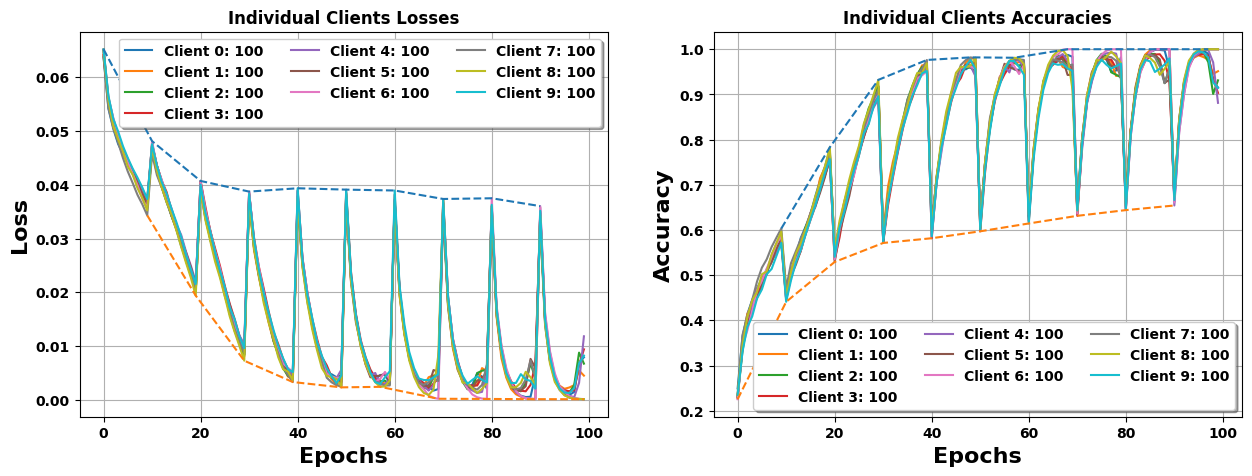

In [55]:
plot_metricss(strategy_fed_prox.client_metrics)


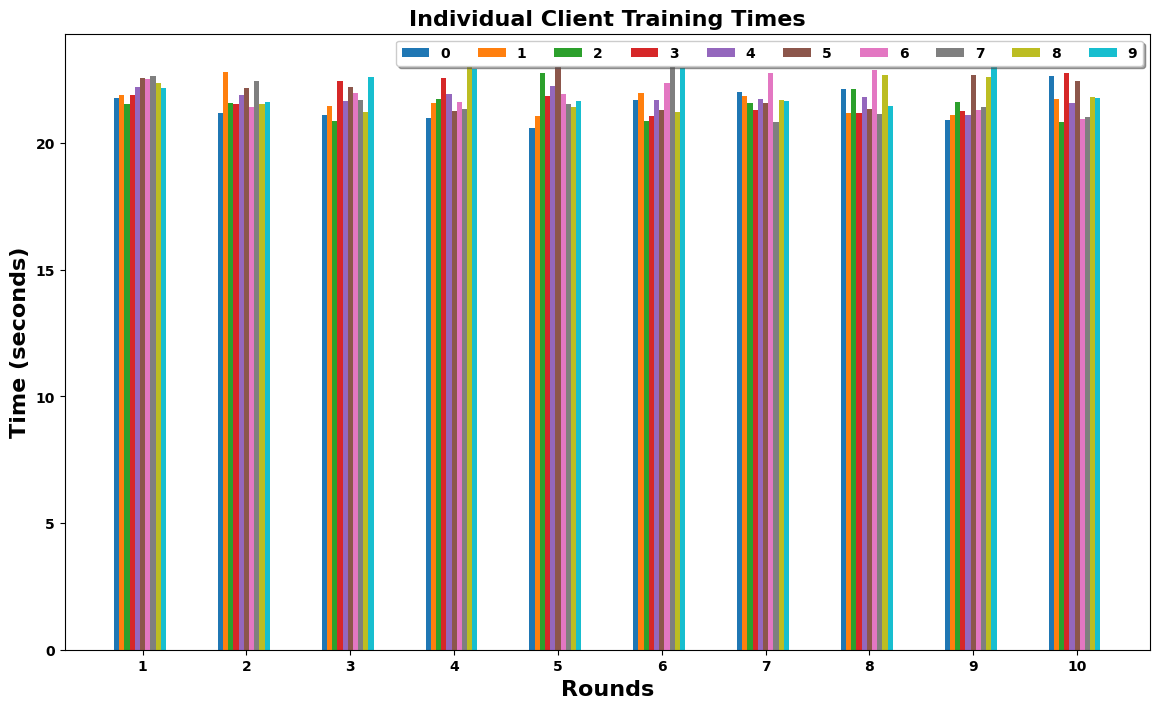

In [56]:
plot_times(strategy_fed_prox.client_training_times)

In [21]:
strategy_fed_avg = FedAvgCustom()

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=10,
    config=fl.server.ServerConfig(num_rounds=10),
    client_resources=client_resources,
    strategy=strategy_fed_avg,
)

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-12-13 10:11:58,638	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 32.0, 'memory': 71158094439.0, 'node:127.0.0.1': 1.0, 'accelerator_type:RTX': 1.0, 'GPU': 1.0, 'object_store_memory': 34782040473.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_gpus': 0.125, 'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6964) [Client 9] get_parameters
(ClientAppActor pid=6964) [Client 0] fit, config: {}
(ClientAppActor pid=6964) Epoch 0: train loss 0.065041, accuracy 0.233333
(ClientAppActor pid=6964) Epoch 1: train loss 0.056125, accuracy 0.349556
(ClientAppActor pid=35024) [Client 6] fit, config: {}
(ClientAppActor pid=6964) Epoch 2: train loss 0.051994, accuracy 0.390222
(ClientAppActor pid=35024) Epoch 0: train loss 0.065756, accuracy 0.226000
(ClientAppActor pid=29860) [Client 4] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=21500) Epoch 0: train loss 0.065425, accuracy 0.211778 [repeated 11x across cluster]
(ClientAppActor pid=39140) [Client 8] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=39140) Epoch 1: train loss 0.055476, accuracy 0.349778 [repeated 18x across cluster]
(ClientAppActor pid=6964) [Client 7] fit, config: {}
(ClientAppActor pid=29100) Epoch 7: train loss 0.041410, accuracy 0.517778 [repeated 20x across cluster]
(ClientApp

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=35024) Epoch 9: train loss 0.036068, accuracy 0.585333 [repeated 2x across cluster]
(ClientAppActor pid=35024) [Client 7] evaluate, config: {}
(ClientAppActor pid=35024) Client 7 loss 0.056811065673828126
(ClientAppActor pid=35024) Client 7 accuracy 0.388
(ClientAppActor pid=6964) [Client 6] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=6964) Client 6 loss 0.05792606425285339 [repeated 4x across cluster]
(ClientAppActor pid=6964) Client 6 accuracy 0.358 [repeated 4x across cluster]
(ClientAppActor pid=39108) [Client 0] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=27784) Client 3 loss 0.05698267769813538 [repeated 5x across cluster]
(ClientAppActor pid=27784) Client 3 accuracy 0.39 [repeated 5x across cluster]
(ClientAppActor pid=27784) [Client 7] fit, config: {}
(ClientAppActor pid=27784) [Client 3] evaluate, config: {}
(ClientAppActor pid=27784) Epoch 0: train loss 0.047444, accuracy 0.450667
(ClientAppActor pid=39140) [Client 1] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=35024) Epoch 0: train loss 0.048062, accuracy 0.443556 [repeated 11x across cluster]
(ClientAppActor pid=29100) [Client 9] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=29860) Epoch 2: train loss 0.041580, accuracy 0.519778 [repeated 20x across cluster]
(ClientAppActor pid=35024) Epoch 5: train loss 0.033452, accuracy 0.612000 [repeated 17x across cluster]
(ClientAppActor pid=27784) [Client 3] fit, config: {}
(ClientAppActor pid=29100) Epoch 6: train loss 0.031727, accuracy 0.638000 [repeated 19x across cluster]
(Cl

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=21500) Epoch 9: train loss 0.023950, accuracy 0.736667 [repeated 5x across cluster]
(ClientAppActor pid=21500) [Client 7] evaluate, config: {}
(ClientAppActor pid=21500) Client 7 loss 0.043028420448303226
(ClientAppActor pid=21500) Client 7 accuracy 0.538
(ClientAppActor pid=29100) [Client 9] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=21500) Client 4 loss 0.043919203877449034 [repeated 4x across cluster]
(ClientAppActor pid=21500) Client 4 accuracy 0.522 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=21500) [Client 0] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=21500) Client 0 loss 0.04564434909820557 [repeated 5x across cluster]
(ClientAppActor pid=21500) Client 0 accuracy 0.504 [repeated 5x across cluster]
(ClientAppActor pid=21500) [Client 2] fit, config: {}
(ClientAppActor pid=21500) Epoch 0: train loss 0.041251, accuracy 0.531111
(ClientAppActor pid=39140) [Client 8] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=39140) Epoch 0: train loss 0.040309, accuracy 0.540444 [repeated 11x across cluster]
(ClientAppActor pid=6964) [Client 7] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39108) Epoch 2: train loss 0.032917, accuracy 0.625333 [repeated 20x across cluster]
(ClientAppActor pid=35024) Epoch 7: train loss 0.016207, accuracy 0.825778 [repeated 18x across cluster]
(ClientAppActor pid=21500) [Client 0] fit, config: {}
(ClientAppActor pid=35024) Epoch 9: train loss 0.010454, accuracy 0.897333 [rep

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=35024) Epoch 9: train loss 0.010510, accuracy 0.890000 [repeated 5x across cluster]
(ClientAppActor pid=35024) [Client 4] evaluate, config: {}
(ClientAppActor pid=35024) Client 4 loss 0.04794796633720398
(ClientAppActor pid=35024) Client 4 accuracy 0.546
(ClientAppActor pid=39108) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=21500) Client 3 loss 0.05061311709880829 [repeated 4x across cluster]
(ClientAppActor pid=21500) Client 3 accuracy 0.536 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=29860) [Client 6] fit, config: {}
(ClientAppActor pid=29860) [Client 8] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=29860) Client 8 loss 0.047239291787147523 [repeated 5x across cluster]
(ClientAppActor pid=29860) Client 8 accuracy 0.542 [repeated 5x across cluster]
(ClientAppActor pid=29860) Epoch 0: train loss 0.039627, accuracy 0.566000
(ClientAppActor pid=29100) [Client 7] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=27784) Epoch 2: train loss 0.026200, accuracy 0.702000 [repeated 11x across cluster]
(ClientAppActor pid=6964) [Client 5] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=29100) Epoch 3: train loss 0.020735, accuracy 0.767333 [repeated 19x across cluster]
(ClientAppActor pid=27784) Epoch 7: train loss 0.008481, accuracy 0.915333 [repeated 18x across cluster]
(ClientAppActor pid=29860) [Client 4] fit, config: {}
(ClientAppActor pid=35024) Epoch 7: train loss 0.008587, accuracy 0.912444 [re

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=27784) Epoch 9: train loss 0.005354, accuracy 0.947111 [repeated 5x across cluster]
(ClientAppActor pid=27784) [Client 1] evaluate, config: {}
(ClientAppActor pid=27784) Client 1 loss 0.05557437396049499
(ClientAppActor pid=27784) Client 1 accuracy 0.566
(ClientAppActor pid=29100) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=35024) Client 7 loss 0.05860797238349914 [repeated 4x across cluster]
(ClientAppActor pid=35024) Client 7 accuracy 0.568 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=27784) [Client 9] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=27784) Client 9 loss 0.06189869117736817 [repeated 5x across cluster]
(ClientAppActor pid=27784) Client 9 accuracy 0.552 [repeated 5x across cluster]
(ClientAppActor pid=27784) [Client 5] fit, config: {}
(ClientAppActor pid=27784) Epoch 0: train loss 0.038606, accuracy 0.593333
(ClientAppActor pid=35024) [Client 6] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=35024) Epoch 0: train loss 0.039362, accuracy 0.587111 [repeated 11x across cluster]
(ClientAppActor pid=21500) [Client 3] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39140) Epoch 2: train loss 0.020399, accuracy 0.776444 [repeated 20x across cluster]
(ClientAppActor pid=35024) Epoch 5: train loss 0.008901, accuracy 0.910889 [repeated 19x across cluster]
(ClientAppActor pid=29100) Epoch 9: train loss 0.003072, accuracy 0.971778 [repeated 16x across cluster]
(ClientAppActor pid=27784) 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=29100) Epoch 9: train loss 0.003239, accuracy 0.971111 [repeated 5x across cluster]
(ClientAppActor pid=29100) [Client 0] evaluate, config: {}
(ClientAppActor pid=29100) Client 0 loss 0.06425213980674743
(ClientAppActor pid=29100) Client 0 accuracy 0.55
(ClientAppActor pid=29860) [Client 8] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=35024) Client 5 loss 0.06265790104866027 [repeated 4x across cluster]
(ClientAppActor pid=35024) Client 5 accuracy 0.608 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=39140) [Client 3] fit, config: {}
(ClientAppActor pid=39140) [Client 2] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=39140) Client 2 loss 0.06881051325798035 [repeated 5x across cluster]
(ClientAppActor pid=39140) Client 2 accuracy 0.552 [repeated 5x across cluster]
(ClientAppActor pid=39140) Epoch 0: train loss 0.037912, accuracy 0.616889
(ClientAppActor pid=39108) [Client 9] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=27784) Epoch 2: train loss 0.016474, accuracy 0.817111 [repeated 12x across cluster]
(ClientAppActor pid=29100) [Client 7] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39108) Epoch 3: train loss 0.012441, accuracy 0.865333 [repeated 20x across cluster]
(ClientAppActor pid=35024) Epoch 6: train loss 0.005493, accuracy 0.944000 [repeated 20x across cluster]
(ClientAppActor pid=39140) [Client 8] fit, config: {}
(ClientAppActor pid=35024) Epoch 8: train loss 0.002383, accuracy 0.982444 [re

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6964) Epoch 9: train loss 0.003680, accuracy 0.966222 [repeated 5x across cluster]
(ClientAppActor pid=6964) [Client 3] evaluate, config: {}
(ClientAppActor pid=6964) Client 3 loss 0.06967225193977356
(ClientAppActor pid=6964) Client 3 accuracy 0.58
(ClientAppActor pid=29860) [Client 2] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=29860) Client 2 loss 0.07192911314964294 [repeated 4x across cluster]
(ClientAppActor pid=29860) Client 2 accuracy 0.564 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6964) [Client 8] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=6964) Client 8 loss 0.06657142543792724 [repeated 5x across cluster]
(ClientAppActor pid=6964) Client 8 accuracy 0.546 [repeated 5x across cluster]
(ClientAppActor pid=6964) [Client 5] fit, config: {}
(ClientAppActor pid=6964) Epoch 0: train loss 0.038616, accuracy 0.614889
(ClientAppActor pid=21500) [Client 7] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=35024) Epoch 0: train loss 0.037569, accuracy 0.623556 [repeated 11x across cluster]
(ClientAppActor pid=29860) [Client 9] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=21500) Epoch 3: train loss 0.008514, accuracy 0.920000 [repeated 18x across cluster]
(ClientAppActor pid=27784) Epoch 7: train loss 0.003096, accuracy 0.972000 [repeated 19x across cluster]
(ClientAppActor pid=6964) Epoch 9: train loss 0.003920, accuracy 0.961778 [repeated 15x across cluster]
(ClientAppActor pid=6964) [Client

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=27784) [Client 3] evaluate, config: {}
(ClientAppActor pid=27784) Client 3 loss 0.07352654266357422
(ClientAppActor pid=27784) Client 3 accuracy 0.56
(ClientAppActor pid=27784) Epoch 9: train loss 0.004533, accuracy 0.954000
(ClientAppActor pid=35024) [Client 8] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=35024) Client 8 loss 0.07081571507453918 [repeated 4x across cluster]
(ClientAppActor pid=35024) Client 8 accuracy 0.528 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6964) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=6964) Client 2 loss 0.07694641423225403 [repeated 5x across cluster]
(ClientAppActor pid=6964) Client 2 accuracy 0.55 [repeated 5x across cluster]
(ClientAppActor pid=6964) [Client 6] fit, config: {}
(ClientAppActor pid=6964) Epoch 0: train loss 0.037389, accuracy 0.634000
(ClientAppActor pid=21500) [Client 3] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=27784) Epoch 0: train loss 0.037760, accuracy 0.626222 [repeated 11x across cluster]
(ClientAppActor pid=29860) [Client 8] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=39140) Epoch 2: train loss 0.012641, accuracy 0.856444 [repeated 20x across cluster]
(ClientAppActor pid=29860) Epoch 4: train loss 0.005011, accuracy 0.950000 [repeated 20x across cluster]
(ClientAppActor pid=6964) [Client 2] fit, config: {}
(ClientAppActor pid=27784) Epoch 7: train loss 0.001181, accuracy 0.995111 [repeated 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=29100) Epoch 9: train loss 0.005124, accuracy 0.951111 [repeated 5x across cluster]
(ClientAppActor pid=29100) [Client 7] evaluate, config: {}
(ClientAppActor pid=29100) Client 7 loss 0.06737362051010132
(ClientAppActor pid=29100) Client 7 accuracy 0.568
(ClientAppActor pid=27784) [Client 6] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=27784) Client 6 loss 0.07919660115242004 [repeated 4x across cluster]
(ClientAppActor pid=27784) Client 6 accuracy 0.56 [repeated 4x across cluster]
(ClientAppActor pid=39108) [Client 0] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=29860) Client 5 loss 0.06974277424812317 [repeated 5x across cluster]
(ClientAppActor pid=29860) Client 5 accuracy 0.57 [repeated 5x across cluster]
(ClientAppActor pid=29860) [Client 5] fit, config: {}
(ClientAppActor pid=29860) Epoch 0: train loss 0.035730, accuracy 0.650667
(ClientAppActor pid=29860) [Client 5] evaluate, config: {}
(ClientAppActor pid=6964) [Client 1] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=39108) Epoch 0: train loss 0.036632, accuracy 0.639778 [repeated 5x across cluster]
(ClientAppActor pid=35024) [Client 8] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=39140) Epoch 2: train loss 0.009706, accuracy 0.900667 [repeated 21x across cluster]
(ClientAppActor pid=27784) Epoch 4: train loss 0.003434, accuracy 0.973778 [repeated 20x across cluster]
(ClientAppActor pid=29860) [Client 4] fit, config: {}
(ClientAppActor pid=39108) Epoch 8: train loss 0.004482, accuracy 0.952667 [repeated 19x across cluster]
(Clie

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=21500) Epoch 9: train loss 0.006196, accuracy 0.933778 [repeated 5x across cluster]
(ClientAppActor pid=21500) [Client 1] evaluate, config: {}
(ClientAppActor pid=21500) Client 1 loss 0.0752408401966095
(ClientAppActor pid=21500) Client 1 accuracy 0.542
(ClientAppActor pid=29860) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=39140) Client 7 loss 0.07076511788368225 [repeated 4x across cluster]
(ClientAppActor pid=39140) Client 7 accuracy 0.56 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=21500) [Client 5] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=21500) Client 5 loss 0.07306717658042908 [repeated 5x across cluster]
(ClientAppActor pid=21500) Client 5 accuracy 0.574 [repeated 5x across cluster]
(ClientAppActor pid=21500) [Client 0] fit, config: {}
(ClientAppActor pid=21500) Epoch 0: train loss 0.033418, accuracy 0.675333
(ClientAppActor pid=6964) [Client 9] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=27784) Epoch 0: train loss 0.034444, accuracy 0.669778 [repeated 11x across cluster]
(ClientAppActor pid=39108) [Client 3] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=39140) Epoch 2: train loss 0.009510, accuracy 0.898444 [repeated 20x across cluster]
(ClientAppActor pid=6964) Epoch 6: train loss 0.000912, accuracy 0.997111 [repeated 18x across cluster]
(ClientAppActor pid=21500) [Client 2] fit, config: {}
(ClientAppActor pid=39108) Epoch 6: train loss 0.001911, accuracy 0.987556 [repe

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=29860) Epoch 9: train loss 0.000139, accuracy 1.000000 [repeated 5x across cluster]
(ClientAppActor pid=29860) [Client 7] evaluate, config: {}
(ClientAppActor pid=29860) Client 7 loss 0.07662723231315613
(ClientAppActor pid=29860) Client 7 accuracy 0.584
(ClientAppActor pid=35024) [Client 6] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=27784) Client 4 loss 0.07852628302574158 [repeated 4x across cluster]
(ClientAppActor pid=27784) Client 4 accuracy 0.554 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 620.18s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.05723900423049927
INFO :      		round 2: 0.04410097271203995
INFO :      		round 3: 0.049344051575660706
INFO :      		round 4: 0.058497073912620545
INFO :      		round 5: 0.06525538291931152
INFO :      		round 6: 0.06858985003232956
INFO :      		round 7: 0.07257468627691269
INFO :      		round 8: 0.0717821907043457
INFO :      		round 9: 0.0755708835721016
INFO :      		round 10: 0.08262381134033203
INFO :      


History (loss, distributed):
	round 1: 0.05723900423049927
	round 2: 0.04410097271203995
	round 3: 0.049344051575660706
	round 4: 0.058497073912620545
	round 5: 0.06525538291931152
	round 6: 0.06858985003232956
	round 7: 0.07257468627691269
	round 8: 0.0717821907043457
	round 9: 0.0755708835721016
	round 10: 0.08262381134033203

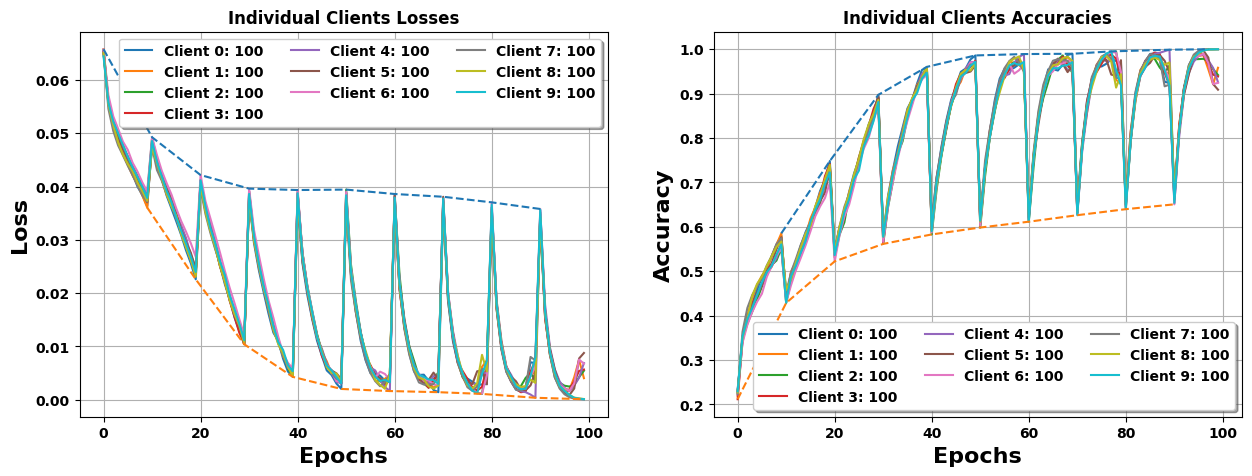

In [59]:
plot_metricss(strategy_fed_avg.client_metrics)

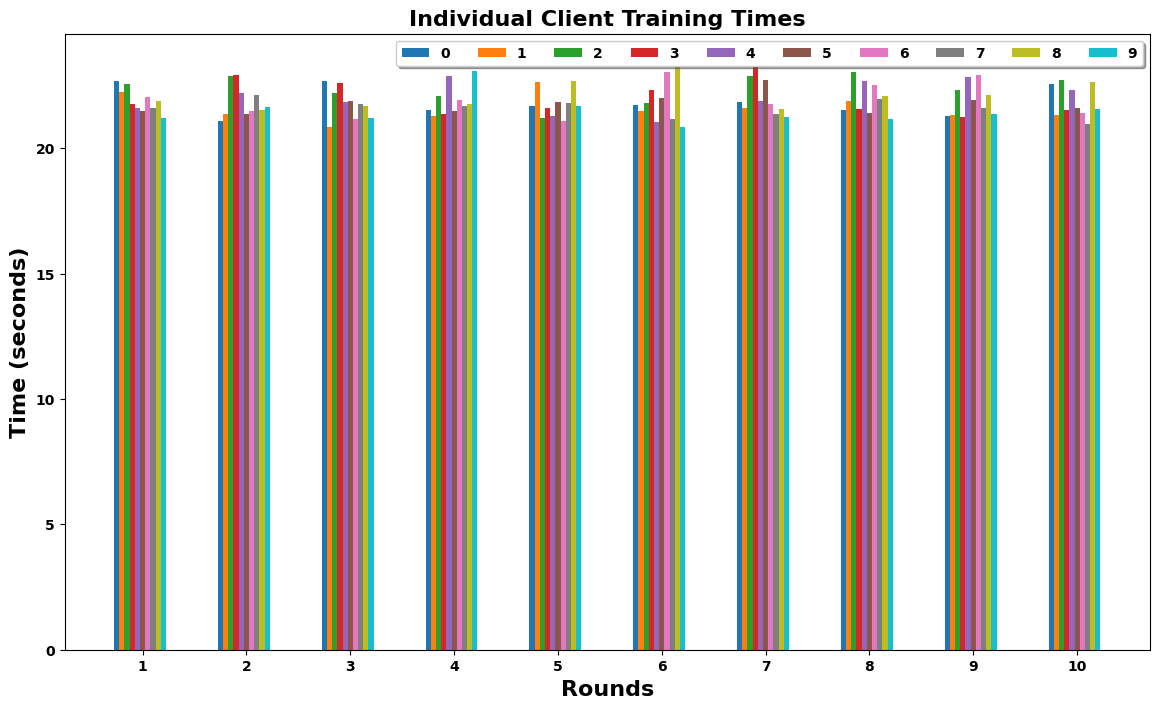

In [60]:
plot_times(strategy_fed_avg.client_training_times)